In [22]:
import os
import pandas as pd
import numpy as np
import string,gzip,pickle,time,json,re,nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from math import sqrt
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from spellchecker import SpellChecker
from datetime import datetime
import matplotlib.pyplot as plt

regex_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')   
local_stopwords = set(stopwords.words('english'))
local_stopwords = [re.sub(r'[^\w\s]','', i) for i in local_stopwords]
stemmer = PorterStemmer()

## Loading serialized preprocessed tweets data frame

In [31]:
tweetsPickle_sentiment_us = pd.read_pickle('tweetsPickle_onlymentions_sent.pickle')
#setting datetime index to allow for temporal analysis
tweetsPickle_sentiment_us.set_index('tDatetime',inplace = True)

# Downloading additional datasets 
## United States Department of Agriculture Economic Research Service
## https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

In [15]:
#Educational attainment for the U.S., States, and counties, 1970-2017 
educationPerState = pd.read_csv('https://raw.githubusercontent.com/Andreas-Melzer/DSFGroup22/master/Assignment%201/data/Education.csv',sep=';')

#Unemployment and median household income for the U.S., States, and counties, 2007-18
unemploymentPerState = pd.read_csv('https://raw.githubusercontent.com/Andreas-Melzer/DSFGroup22/master/Assignment%201/data/Unemployment.csv',sep=';')

#remove all data on county level
educationPerState = educationPerState[ (pd.isna(educationPerState['2013 Rural-urban Continuum Code']) == True) & (pd.isna(educationPerState['2003 Rural-urban Continuum Code']) == True) ]
unemploymentPerState = unemploymentPerState[ (pd.isna(unemploymentPerState['Rural_urban_continuum_code_2013']) == True)]

# Average percentage of  postive tweets per candidate /state

In [83]:
!pip install geopandas

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
    Complete output from command python setup.py egg_info:
    INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
    ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    
    ----------------------------------------


Command "python setup.py egg_info" failed with error code 1 in C:\Users\Andreas\AppData\Local\Temp\pip-install-l0d09sfj\rasterio\
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [84]:
import geopandas as gpd
import geoplot
from shapely.geometry import Point, Polygon

ModuleNotFoundError: No module named 'geoplot'

In [115]:
candidateSentimentState = tweetsPickle_sentiment_us[['candidate','textblobSentimentDummy','state']].groupby(['candidate','textblobSentimentDummy','state']).size()
hillarySentiment = candidateSentimentState['Hillary Clinton']['POS'].groupby('state').sum() / (candidateSentimentState['Hillary Clinton'][['POS','NEG']].groupby('state').sum())
trumpSentiment = candidateSentimentState['Donald Trump']['POS'].groupby('state').sum() / (candidateSentimentState['Donald Trump'][['POS','NEG']].groupby('state').sum())

sentimentDF = pd.DataFrame(trumpSentiment,columns = ['trumpSentiment'])
sentimentDF = sentimentDF.join(pd.DataFrame(hillarySentiment,columns =['hillarySentiment']))

In [121]:
usaSHP = gpd.read_file('states21/states.shp')
usaSHP['STATE_NAME'][usaSHP['STATE_NAME'] == 'District of Columbia'] = 'Dist. of Columbia'

C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [122]:
usaSHP = usaSHP.join(sentimentDF, on = 'STATE_NAME')

In [162]:
sm.to_rgba(0.5)

(0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)

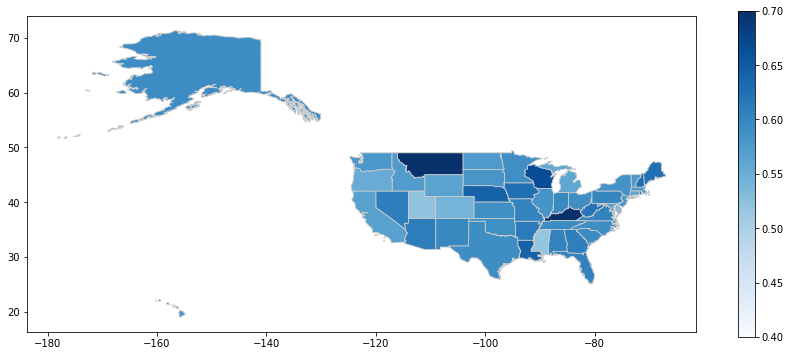

In [173]:
variable = 'trumpSentiment'
vmin, vmax = 0.4, 0.7

fig, ax = plt.subplots(1, figsize=(15, 6))
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
usaSHP.plot(column = variable, 
            cmap='Blues',
            vmin=vmin, 
            vmax =vmax, 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8')
cbar = fig.colorbar(sm)

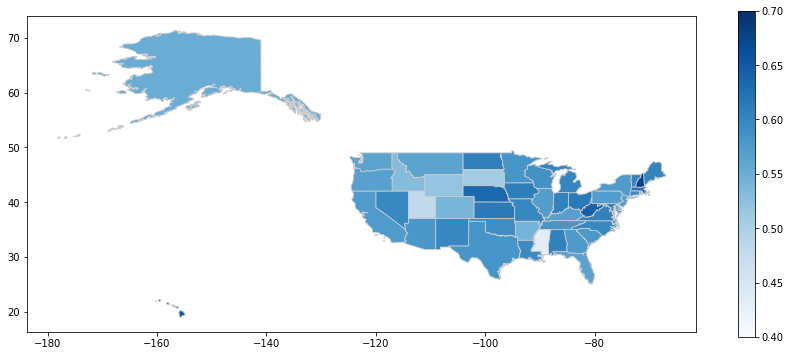

In [171]:
variable = 'hillarySentiment'
vmin, vmax = 0.4, 0.7

fig, ax = plt.subplots(1, figsize=(15, 6))
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
usaSHP.plot(column = variable, 
            cmap='Blues',
            vmin=vmin, 
            vmax =vmax, 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8')
cbar = fig.colorbar(sm)